In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import wandb library
import wandb

# Log in to wandb using your API key
wandb.login(key='5656979c25c03784238533b8e79512ab61bf94e2')

print("Logged in to wandb successfully.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hadiabbas223 (hadiabbas223-iba-institute-of-business-administration). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in to wandb successfully.


In [3]:
# Paths to the CSV files
train_csv_path = '/content/drive/MyDrive/IMDB dataset/test.csv'
test_csv_path = '/content/drive/MyDrive/IMDB dataset/test.csv'

print("Paths to the CSV files set successfully.")

Paths to the CSV files set successfully.


In [4]:
# Import necessary libraries
from peft import LoraConfig, get_peft_model
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import re

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# Load datasets
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

# Convert sentiment to numeric labels
train_data['label'] = [1 if x == "positive" else 0 for x in train_data['sentiment']]
test_data['label'] = [1 if x == "positive" else 0 for x in test_data['sentiment']]

# Drop the original sentiment column
train_data = train_data.drop('sentiment', axis=1)
test_data = test_data.drop('sentiment', axis=1)

# Cleaning function
def cleaning(s):
    s = str(s)
    s = s.replace("", " ")
    s = re.sub('\s\W', ' ', s)
    s = re.sub('\W,\s', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+', ' ', s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co", "")
    s = s.replace("https", "")
    s = s.replace("[\w*", " ")
    s = s.replace(".:", " ")
    return s

# Apply cleaning function
train_data['review'] = train_data['review'].apply(cleaning)
test_data['review'] = test_data['review'].apply(cleaning)

# Extract texts and labels
train_texts, train_labels = train_data['review'], train_data['label']
test_texts, test_labels = test_data['review'], test_data['label']

# Reset index
train_texts.reset_index(drop=True, inplace=True)
test_texts.reset_index(drop=True, inplace=True)

print("Data cleaning and preparation completed.")

Data cleaning and preparation completed.


In [10]:
# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=256)

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels.tolist())
test_dataset = IMDbDataset(test_encodings, test_labels.tolist())

# Use smaller subsets of data for experimentation due to limited resources
train_sample = torch.utils.data.Subset(train_dataset, range(10000))  # Train on 500 samples
test_sample = torch.utils.data.Subset(test_dataset, range(5000))    # Test on 100 samples

print("Data tokenization completed.")

Data tokenization completed.


In [11]:
def fine_tune_model(config_name, learning_rate, num_epochs, batch_size, lora_r, lora_alpha, lora_dropout):
    # Define the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained model
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    model.to(device)  # Move the model to the selected device

    # Configure LoRA
    lora_config = LoraConfig(
        task_type="SEQ_CLS",  # Sequence classification
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=["roberta.encoder.layer.0.attention.self.query",
                        "roberta.encoder.layer.0.attention.self.key",
                        "roberta.encoder.layer.0.attention.self.value",
                        "roberta.encoder.layer.0.attention.output.dense"],
    )
    model = get_peft_model(model, lora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{config_name}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_dir=f'./logs_{config_name}',
        logging_steps=10,
        disable_tqdm=False,
        no_cuda=(device.type == "cpu"),
        save_total_limit=2,  # Limit checkpoints saved
        load_best_model_at_end=True  # Ensure best model is loaded
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_sample,
        eval_dataset=test_sample,
        tokenizer=tokenizer,
    )

    # Fine-tune the model
    print(f"\nFine-tuning model: {config_name}...")
    trainer.train()

    # Evaluate the model
    print("\n--- Evaluating the Model ---")
    eval_results = trainer.evaluate()
    print(f"\nEvaluation Results for {config_name}: {eval_results}")

    # Detailed evaluation metrics
    predictions = trainer.predict(test_sample)
    raw_preds = predictions.predictions  # Raw logits
    true_labels = predictions.label_ids  # Ground truth labels
    predicted_labels = np.argmax(raw_preds, axis=1)  # Predicted labels (argmax over logits)

    # Classification metrics
    print("\n--- Classification Report ---")
    print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    # Visualize confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Save the results to a CSV for further analysis
    result_record = {
        "Config": config_name,
        "Learning Rate": learning_rate,
        "Epochs": num_epochs,
        "Batch Size": batch_size,
        "LoRA Rank (r)": lora_r,
        "LoRA Alpha": lora_alpha,
        "LoRA Dropout": lora_dropout,
        "Eval Results": eval_results,
    }
    results_df = pd.DataFrame([result_record])
    results_df.to_csv(f"experiment_results_{config_name}.csv", index=False)
    print(f"\nResults saved to 'experiment_results_{config_name}.csv'")

    return eval_results


Running experiment: Config_1
Configuration: {'name': 'Config_1', 'learning_rate': 5e-05, 'num_epochs': 1, 'batch_size': 2, 'lora_r': 4, 'lora_alpha': 8, 'lora_dropout': 0.1}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-16d0021e7039>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Fine-tuning model: Config_1...


Epoch,Training Loss,Validation Loss
1,0.683500,0.693899



--- Evaluating the Model ---



Evaluation Results for Config_1: {'eval_loss': 0.6938990950584412, 'eval_runtime': 77.9395, 'eval_samples_per_second': 64.152, 'eval_steps_per_second': 32.076, 'epoch': 1.0}

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66      2441
    Positive       0.00      0.00      0.00      2559

    accuracy                           0.49      5000
   macro avg       0.24      0.50      0.33      5000
weighted avg       0.24      0.49      0.32      5000


--- Confusion Matrix ---
[[2440    1]
 [2559    0]]


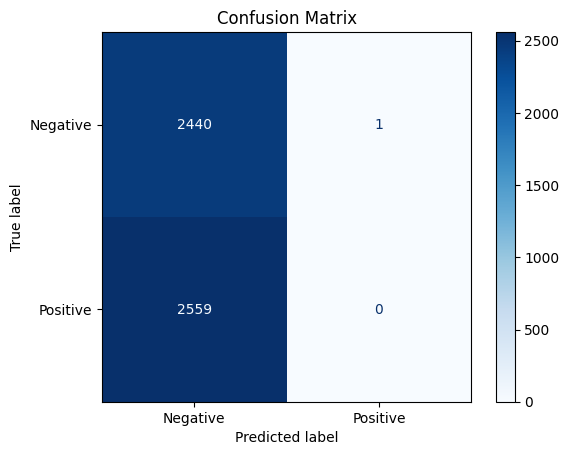


Results saved to 'experiment_results_Config_1.csv'

Running experiment: Config_2
Configuration: {'name': 'Config_2', 'learning_rate': 3e-05, 'num_epochs': 1, 'batch_size': 2, 'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.2}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-16d0021e7039>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Fine-tuning model: Config_2...


Epoch,Training Loss,Validation Loss
1,0.683900,0.693099



--- Evaluating the Model ---



Evaluation Results for Config_2: {'eval_loss': 0.6930992603302002, 'eval_runtime': 78.0459, 'eval_samples_per_second': 64.065, 'eval_steps_per_second': 32.032, 'epoch': 1.0}

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.49      0.99      0.65      2441
    Positive       0.50      0.01      0.01      2559

    accuracy                           0.49      5000
   macro avg       0.49      0.50      0.33      5000
weighted avg       0.49      0.49      0.33      5000


--- Confusion Matrix ---
[[2425   16]
 [2543   16]]


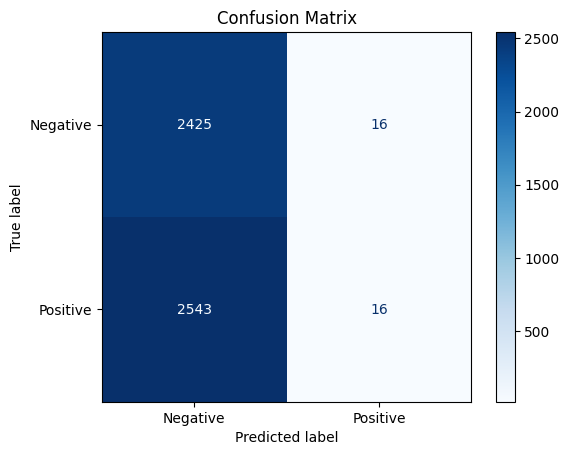


Results saved to 'experiment_results_Config_2.csv'

Running experiment: Config_3
Configuration: {'name': 'Config_3', 'learning_rate': 1e-05, 'num_epochs': 2, 'batch_size': 2, 'lora_r': 2, 'lora_alpha': 4, 'lora_dropout': 0.05}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-16d0021e7039>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Fine-tuning model: Config_3...


Epoch,Training Loss,Validation Loss
1,0.684600,0.692880
2,0.694600,0.692809



--- Evaluating the Model ---



Evaluation Results for Config_3: {'eval_loss': 0.6928094625473022, 'eval_runtime': 77.3708, 'eval_samples_per_second': 64.624, 'eval_steps_per_second': 32.312, 'epoch': 2.0}

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.50      0.92      0.65      2441
    Positive       0.62      0.12      0.21      2559

    accuracy                           0.51      5000
   macro avg       0.56      0.52      0.43      5000
weighted avg       0.56      0.51      0.42      5000


--- Confusion Matrix ---
[[2245  196]
 [2242  317]]


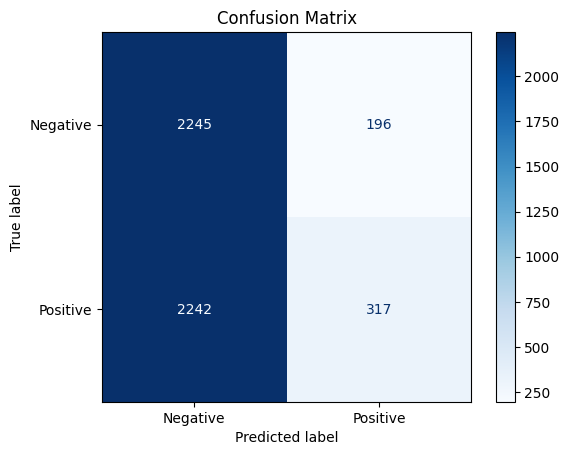


Results saved to 'experiment_results_Config_3.csv'

Summary of All Experiments:
     Config  Learning Rate  Epochs  Batch Size  LoRA Rank (r)  LoRA Alpha  \
0  Config_1        0.00005       1           2              4           8   
1  Config_2        0.00003       1           2              8          16   
2  Config_3        0.00001       2           2              2           4   

   LoRA Dropout                                       Eval Results  
0          0.10  {'eval_loss': 0.6938990950584412, 'eval_runtim...  
1          0.20  {'eval_loss': 0.6930992603302002, 'eval_runtim...  
2          0.05  {'eval_loss': 0.6928094625473022, 'eval_runtim...  


In [12]:
# Experiment configurations
configs = [
    {"name": "Config_1", "learning_rate": 5e-5, "num_epochs": 1, "batch_size": 2, "lora_r": 4, "lora_alpha": 8, "lora_dropout": 0.1},
    {"name": "Config_2", "learning_rate": 3e-5, "num_epochs": 1, "batch_size": 2, "lora_r": 8, "lora_alpha": 16, "lora_dropout": 0.2},
    {"name": "Config_3", "learning_rate": 1e-5, "num_epochs": 2, "batch_size": 2, "lora_r": 2, "lora_alpha": 4, "lora_dropout": 0.05},
]

# Run experiments and collect results
results = []

for config in configs:
    print(f"\nRunning experiment: {config['name']}")
    print(f"Configuration: {config}")

    # Call the fine-tuning function and get evaluation results
    eval_result = fine_tune_model(
        config_name=config["name"],
        learning_rate=config["learning_rate"],
        num_epochs=config["num_epochs"],
        batch_size=config["batch_size"],
        lora_r=config["lora_r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=config["lora_dropout"],
    )

    # Store the results
    results.append({
        "Config": config["name"],
        "Learning Rate": config["learning_rate"],
        "Epochs": config["num_epochs"],
        "Batch Size": config["batch_size"],
        "LoRA Rank (r)": config["lora_r"],
        "LoRA Alpha": config["lora_alpha"],
        "LoRA Dropout": config["lora_dropout"],
        "Eval Results": eval_result,
    })

# Print the summary of all experiments
results_df = pd.DataFrame(results)
print("\nSummary of All Experiments:")
print(results_df)

In [13]:
import pandas as pd

# Create a DataFrame for results
results_df = pd.DataFrame(results)

# Print a summary of all experiments
print("\nSummary of All Experiments:")
print(results_df)

# Save the results to a CSV for further analysis
results_df.to_csv("experiment_results.csv", index=False)
print("\nResults saved to 'experiment_results.csv'")



Summary of All Experiments:
     Config  Learning Rate  Epochs  Batch Size  LoRA Rank (r)  LoRA Alpha  \
0  Config_1        0.00005       1           2              4           8   
1  Config_2        0.00003       1           2              8          16   
2  Config_3        0.00001       2           2              2           4   

   LoRA Dropout                                       Eval Results  
0          0.10  {'eval_loss': 0.6938990950584412, 'eval_runtim...  
1          0.20  {'eval_loss': 0.6930992603302002, 'eval_runtim...  
2          0.05  {'eval_loss': 0.6928094625473022, 'eval_runtim...  

Results saved to 'experiment_results.csv'


**CONCLUSION**

Config_3 achieved the lowest eval_loss (0.6928) with a lower learning rate and higher epochs but smaller LoRA Rank and Alpha.

Config_2 performed slightly better than Config_1 in terms of eval_loss but required a higher LoRA Rank and Alpha with a dropout of 0.20.

Config_1 had the highest eval_loss (0.6939) despite a moderate LoRA configuration and dropout.

Lower learning rates and higher epochs (e.g., Config_3) might lead to better model performance (lower eval_loss).